# Calcul Formel

In [11]:
import sympy
sympy.init_printing() 

In [12]:
from sympy import Function, Derivative, Eq, symbols
from sympkf import SymbolicPKF, t, PDESystem, Expectation

In [13]:
x = symbols('x')
u = Function('u')(t, x)
c = Function('c')(t,x)

In [14]:
dynamics = [Eq(Derivative(c,t), u*Derivative(c,x)), Eq(Derivative(u,t),0)]
display(dynamics)

In [15]:
dynamics = PDESystem(dynamics)
dynamics

PDE System :
        prognostic functions : c(t, x), u(t, x)
        constant functions   : 
        exogeneous functions : 
        constants            : 
        

In [16]:
pkf_advection = SymbolicPKF(dynamics)

In [17]:
for equation in pkf_advection.in_metric:
    display(equation)

TypeError: Expectation._has() takes 2 positional arguments but 3 were given

In [ ]:
for key, value in pkf_advection.subs_tree.items():
    display({key:value})

In [ ]:
for term in pkf_advection.unclosed_terms:
    display(term)

In [ ]:
for equation in pkf_advection._epsilon_system:
    display(equation)

# Eperience numérique

**Definition of the physical domain of computation**

In [9]:
from sympy import Integer
from sympkf import FDModelBuilder

g = pkf_advection.fields[u].metric[0] # metric tensor
s = pkf_advection.fields[u].aspect[0] # aspect tensor

# loc. Gaussian closure of P18 in metric form, then in aspect form
P18_closure = Integer(3)*g**Integer(2)-Integer(2)*Derivative(g,x,2)
P18_closure = P18_closure.subs(g,1/s).doit().expand()

# Introduction of the closure as a dictionnary
unclosed_term = list(pkf_advection.unclosed_terms)[0]
pkf_advection.set_closure({unclosed_term:P18_closure})

# Build a numerical code at runtime
exec(FDModelBuilder(pkf_advection.in_aspect, class_name='ClosedPKFAdvection').code)
closed_pkf_advection = ClosedPKFAdvection(shape=(241,))

TypeError: Expectation._has() takes 2 positional arguments but 3 were given

In [17]:
import matplotlib.pyplot as plt

In [18]:
def plot_results(data, label=None, labelx=True, title=None, save_file=None, normalisation=None, 
                 selected_times=None,style=None, name=None, alpha=1., bolds=[0., 1.]):
    
    normalisation = 1. if normalisation is None else normalisation
                 
    selected_times = [time for time in data] if selected_times is None else selected_times
                 
    style = 'k' if style is None else style
                 
    for time in selected_times:
        lalpha = alpha if time in bolds else 0.2
        lname = name if time==selected_times[-1] else None
        plt.plot(domain.x[0],data[time]/normalisation, style, alpha = lalpha, label=lname)
                 
    if labelx:
        plt.xlabel('$x/D$', fontsize=15)
    if label:
        plt.ylabel(label, fontsize=15)
    if title:
        plt.title(title)
    if save_file:
        plt.savefig(save_file)

In [19]:
domain = closed_pkf_advection

In [20]:
n = domain.shape[0]
domain.shape, domain.lengths

C:\Users\vince\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\vince\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\vince\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\vince\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The MathtextBa

**Set initial fields**

In [21]:
# initialisation du champs U
Umax = 0.5
U = np.array(domain.shape[0]*[Umax])

# initialisation du champs c
cmax = 1
c0 = cmax*( 1+np.cos(2*np.pi/ domain.lengths[0]  *(domain.x[0]-0.25)) ) *0.5

# initialisation de la Variance
Vc0 = np.array([(0.01*cmax)**2]*n)
Vu0 = np.array([(0.01*Umax)**2]*n)
Vcu = np.array([(0.01*max(Umax,cmax))**2]*n)


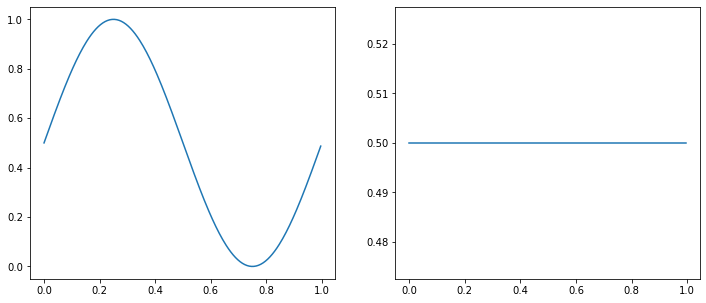

In [22]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(domain.x[0], c0)
plt.subplot(122)
plt.plot(domain.x[0], U)

## Ensembliste

In [23]:
lhc = 0.1
lhu = 0.1

gauss_c = lambda dx : np.exp(-0.5*dx**2/lhc**2) 
gauss_u = lambda dx : np.exp(-0.5*dx**2/lhu**2) 

correlation_c = gauss_c(domain.x[0]-domain.x[0][domain.shape[0]//2])
correlation_u = gauss_u(domain.x[0]-domain.x[0][domain.shape[0]//2])

spectrum_c = np.abs(np.fft.fft(correlation_c))
spectrum_u = np.abs(np.fft.fft(correlation_u))

std_spectrum_c = np.sqrt(spectrum_c)
std_spectrum_u = np.sqrt(spectrum_u)

def make_sample():
    zeta = np.random.normal(size=domain.shape[0]*2)
    zeta_c = np.fft.fft(zeta[0:domain.shape[0]])
    zeta_u = np.fft.fft(zeta[domain.shape[0]:])
    
    
    ef_c = np.fft.ifft(std_spectrum_c * zeta_c)
    ef_u = np.fft.ifft(std_spectrum_u * zeta_u)
    
    ef_c = np.real(ef_c)
    ef_u = np.real(ef_u)
    
    return (ef_c, ef_u)

def make_error_ensemble(variance, Ne):
    return np.array([np.concatenate((make_sample()[0], make_sample()[1])) for k in range(Ne)])


def make_init_ensemble(mean, variance, ef):
    return (mean[0] + np.sqrt(variance[0])*ef[0], mean[1] + np.sqrt(variance[1])*ef[1])

Text(0.5, 1.0, 'Homogenous correlation_u function')

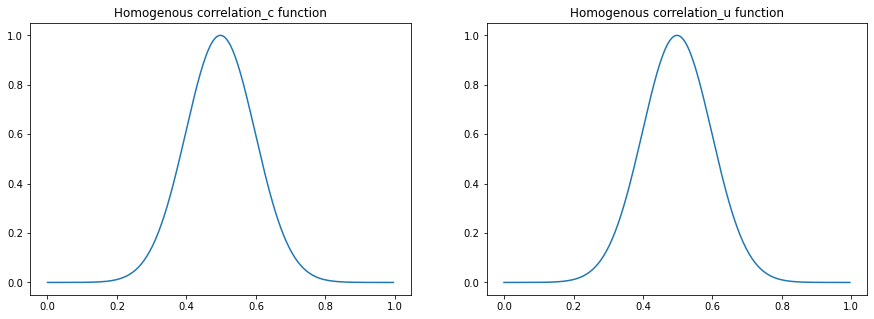

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(domain.x[0], correlation_c)
plt.title('Homogenous correlation_c function')
plt.subplot(122)
plt.plot(domain.x[0], correlation_u)
plt.title('Homogenous correlation_u function')

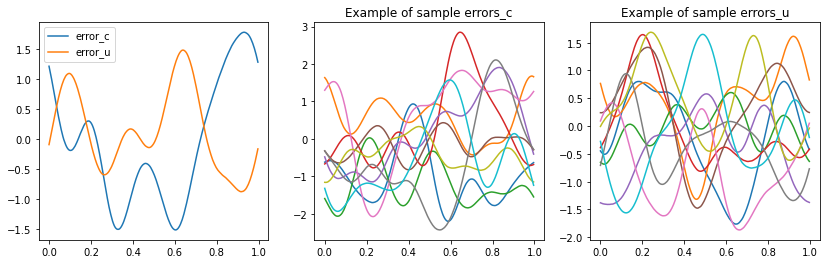

In [25]:
error_c = make_sample()[0]
error_u = make_sample()[1]

plt.figure(figsize=(14,4))
plt.subplot(131)
plt.plot(domain.x[0], error_c)
plt.plot(domain.x[0], error_u)
plt.legend(["error_c","error_u"])

K = 10 # nombre de membre

plt.subplot(132)
for i in range(K):
    plt.plot(domain.x[0], make_sample()[0])
plt.title("Example of sample errors_c")

plt.subplot(133)
for i in range(K):
    plt.plot(domain.x[0], make_sample()[1])
plt.title("Example of sample errors_u");

In [26]:
Ne = 1000

V = [Vc0.max(), Vu0.max()]
mean = [c0, U]

ef = make_error_ensemble(V, Ne)

# [ensemble_c, ensemble_u] = make_init_ensemble(mean, V,  ef)

**plot d'un membre de l'ensemble**

In [27]:
plt.plot(domain.x[0], U_ensemble[0])
plt.plot(domain.x[0], c_ensemble[0])
plt.legend(["U(x)", "c(x)"])

NameError: name 'U_ensemble' is not defined

**validation de l'ensemble**

(482, 482)


C:\Users\vince\AppData\Local\Temp/ipykernel_43656/1876373691.py:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


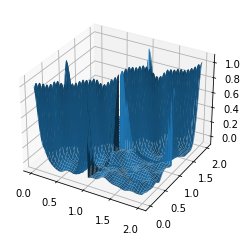

In [28]:
co = (ef.T @ ef)/Ne
print(co.shape)

d = np.concatenate((domain.x[0], 1+ domain.x[0]))

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
x, y = np.meshgrid(d,d)
ax.plot_surface(x,y,co)
plt.show()

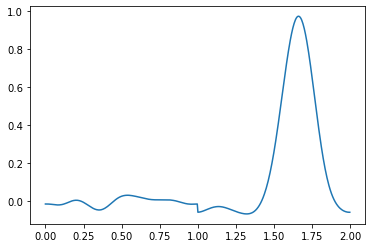

In [29]:
plt.plot(d, co[400])

In [30]:
co.shape

C:\Users\vince\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\vince\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\vince\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\vince\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The MathtextBa